In [1]:
# -*- coding: UTF-8 -*-
%matplotlib inline
from point_location import min_triangle as mint
from point_location.geo.shapes import Point, Polygon, Triangle
from point_location.geo.generator import randomConvexPolygon
from point_location.geo.drawer import plot, plotPoints
import matplotlib.pylab as plt
import numpy as np
from random import shuffle
import os
import signal
from datetime import datetime as dt
import pandas as pd

In [14]:
class TimeoutException(Exception):   # Custom exception class
    pass

def timeout_handler(signum, frame):   # Custom signal handler
    raise TimeoutException

# Change the behavior of SIGALRM
signal.signal(signal.SIGALRM, timeout_handler)

def toNumpy(points):
    return np.array(map(lambda p: p.np(), points), np.float32)

In [15]:
X_orig = np.loadtxt('not_used/data/X.csv', delimiter=",")
N, M = X_orig.shape
    
num_iter = 10
num_vals = M*(M-1)/2

In [16]:


def get_area(X):
    while True:
        points = [Point(*tuple(p)) for p in X]
        poly = Polygon(points)
        
        # Unknown value error occurs randomly
        min_tri = mint.minTriangle(poly)

        area = min_tri.area()
        
        # Unknown value error occurs randomly
        if area < 0.001: continue
            
        break
        
    return points, min_tri, area


subsets = []
for n in range(num_iter):
    subsets.append(np.random.randint(0,N,size=N))


P = np.zeros((M, M))
T = np.zeros((M, M))
C = np.zeros((M, M))

for i in range(M):
    print i, "vs...",
    for j in range(M):
        if j <= i: continue
            
        # tmp
        if i == 1 and j == 2:
            pass
        else:
            continue
            
        Xpair_orig = X_orig[:,[i,j]]
        
        areas_s_orig = []
        areas_s_shuf = []
        
        # Bootstrapping
        t = 0
        for n in range(num_iter):
            subset_indices = np.array(list(set(subsets[n])))
            
            Xpair_s_orig = Xpair_orig[subset_indices,:]
            Xpair_s_shuf = Xpair_s_orig.copy()
            for i in range(2):
                np.random.shuffle(Xpair_s_shuf[:,i])
            
            signal.setitimer(signal.ITIMER_REAL,0.02)
            #start = dt.now()
            try:
                points_s_orig, min_tri_s_orig, tri_s_area_orig = get_area(Xpair_s_orig)
                points_s_shuf, min_tri_s_shuf, tri_s_area_shuf = get_area(Xpair_s_shuf)
                signal.setitimer(signal.ITIMER_REAL,0)
            except ValueError as e: continue
            except TimeoutException as e: t+=1; continue
            else: signal.setitimer(signal.ITIMER_REAL,0)
            #print n, (dt.now() - start)
            
            areas_s_orig.append(tri_s_area_orig)
            areas_s_shuf.append(tri_s_area_shuf)
        
        P[i,j] = np.mean(np.array(areas_s_orig) >= np.array(areas_s_shuf))
        T[i,j] = np.mean(areas_s_shuf) / np.mean(areas_s_orig)
        C[i,j] = len(areas_s_shuf)
        
        print "%d(%d)" % (j,t),
        
    print

0 vs...
1 vs... 2(0)
2 vs...
3 vs...
4 vs...
5 vs...
6 vs...
7 vs...
8 vs...
9 vs...


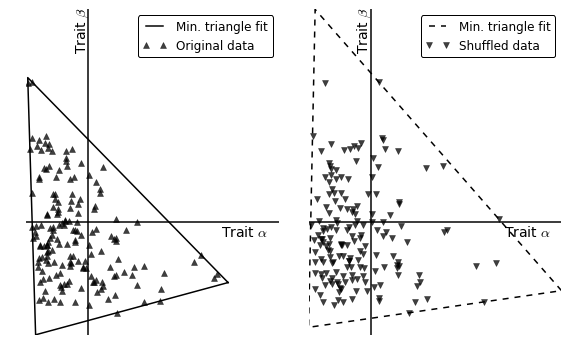

In [95]:
x, y = zip(*tuple([tuple(xy) for xy in toNumpy(min_tri_s_orig.points)] + 
                  [tuple(xy) for xy in toNumpy(min_tri_s_shuf.points)]))

xdom = [min(x),max(x)]; ydom = [min(y),max(y)]

plt.figure(figsize=(8,5))

ax1 = plt.subplot(1,2,1)
plot(min_tri_s_orig, style='k-', linewidth=1.5, label="Min. triangle fit")
plotPoints(points_s_orig, style='k^', alpha=0.75, label="Original data")
ax1.plot(np.linspace(min(x),max(x),100),[0]*100,c="k", lw=1.5)
ax1.plot([0]*100,np.linspace(min(y),max(y),100),c="k", lw=1.5)
ax1.text(0-0.08,max(y)-0.15,r'Trait $\beta$',rotation=90, fontsize=14)
ax1.text(max(x)-0.3, 0-0.2,r'Trait $\alpha$', fontsize=14)
plt.xlim(xdom); plt.ylim(ydom)
plt.axis('off')
plt.legend(fontsize=12, fancybox=True)

ax2 = plt.subplot(1,2,2)
plot(min_tri_s_shuf, style='k--', linewidth=1.5, label="Min. triangle fit")
plotPoints(points_s_shuf, style='kv', alpha=0.75, label="Shuffled data")
ax2.plot(np.linspace(min(x),max(x),100),[0]*100,c="k", lw=1.5)
ax2.plot([0]*100,np.linspace(min(y),max(y),100),c="k", lw=1.5)
ax2.text(0-0.08,max(y)-0.15,r'Trait $\beta$',rotation=90, fontsize=14)
ax2.text(max(x)-0.3, 0-0.2,r'Trait $\alpha$', fontsize=14)
plt.xlim(xdom); plt.ylim(ydom)
plt.axis('off')
plt.legend(fontsize=12, fancybox=True)

plt.tight_layout()

plt.savefig("/Users/ulfaslak/Dropbox/school/sem12/MScProject/Academic/master_thesis/figures/pareto_clustering1.pdf")

In [105]:
Polygon(min_tri_s_orig.points)

In [43]:
tmp = np.empty((6,2))
tmp[:,1] = toNumpy(min_tri_s_shuf.points).reshape((1,6))

In [113]:
a = toNumpy(min_tri_s_shuf.points)
b = toNumpy(min_tri_s_shuf.points)
for i,j in zip(a,b):
    print i,j
    break


[ 0.99582732 -1.01204085] [ 0.99582732 -1.01204085]


In [ ]:
print "orig", np.mean(areas_s_orig)
print "shuf", np.mean(areas_s_shuf)
print "pval", np.mean(np.array(areas_s_orig) >= np.array(areas_s_shuf))
print len(areas_s_shuf)
plt.hist(areas_s_orig,alpha=0.4,color="green")
plt.hist(areas_s_shuf,alpha=0.4,color="yellow")
plt.show()

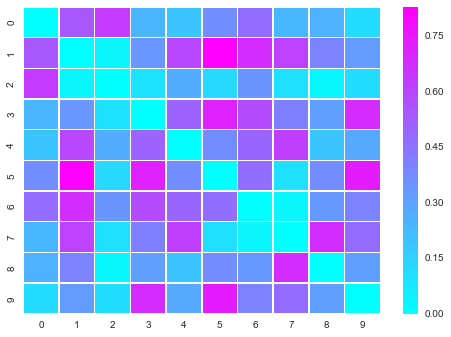

In [25]:
sns.heatmap(pd.DataFrame(P),cmap='cool')
plt.show()

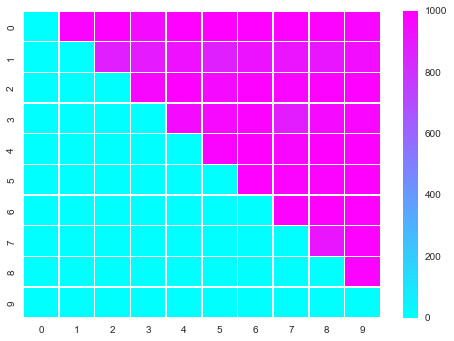

In [74]:
sns.heatmap(pd.DataFrame(T),cmap='cool')
plt.show()

In [23]:
from sklearn.cluster import DBSCAN

In [44]:
T = 1/T
np.fill_diagonal(T,0)

In [65]:
dbscan = DBSCAN(eps=0.1, metric='precomputed')
db = dbscan.fit(P)
db.labels_

array([-1,  0,  0,  0, -1, -1, -1,  0,  0, -1])

In [72]:
dbscan = DBSCAN(eps=0.82, metric='precomputed')
db = dbscan.fit(T)
db.labels_

array([ 0,  0,  0,  0, -1,  0,  0,  0,  0,  0])

In [73]:
pd.DataFrame(C)

,0,1,2,3,4,5,6,7,8,9
0,0,986,997,957,996,998,996,993,987,977
1,0,0,880,895,933,878,929,918,915,949
2,0,0,0,972,997,964,989,980,991,993
3,0,0,0,0,955,965,988,888,960,977
4,0,0,0,0,0,983,999,976,997,998
5,0,0,0,0,0,0,994,986,982,1000
6,0,0,0,0,0,0,0,990,999,994
7,0,0,0,0,0,0,0,0,917,989
8,0,0,0,0,0,0,0,0,0,983
9,0,0,0,0,0,0,0,0,0,0


In [75]:
C += C.T
np.fill_diagonal(C,1000)

In [11]:
sns.heatmap(pd.DataFrame(C),cmap='cool')
plt.show()

NameError: name 'sns' is not defined

In [4]:
from point_location import min_triangle as mint
from point_location.geo.shapes import Point, Polygon
import numpy as np
import signal

class TimeoutException(Exception):   # Custom exception class
    pass

def timeout_handler(signum, frame):   # Custom signal handler
    raise TimeoutException

class Build_S:
    """Build Similarity matrices
    
    Computes p-values and T-ratios for trait pairs. Uses an implementation
    of minimal enclosing triangle computation [O'Rourke 86]. Some of the 
    trait pairs have boundaries at which most datapoints lie, causing the 
    algorithm to converge extremely slow, when the chosen subset contains 
    a lot of points on the boundary. It happens because the minimal enclosing 
    triangle must must enclose a very "narrow" and "tall" set of points, 
    causing the length of one edge to go towards infinity. To deal with this 
    inevitable problem, a timeout condition is established, killing triangle 
    computations taking longer than 200 milliseconds. This means that some 
    of the p-values are computed from a smaller number of iterations, but it 
    does not result in significantly worse results.

    It should be stated that estimating triangularness using this approach is
    SENSITIVE to datadistributions with nattow convex hulls, where the triangle
    enclosing the original data can grow extremely wide/tall, rendering the area
    of the shuffled data triangle smaller, even though it is in fact less triangular.
    
    Triangle computation has TC O(N*log(N)) and the implementation in this class
    (without regards for triangle computation) has TC O(M^2*num_iter), so effective
    TC should be O(M^2*num_iter*N*log(N)).
    
    Parameters
    ----------
    X : numpy.ndarray
        N x M matrix where N is samples and M is traits
    num_iter : int
        Number of bootstrapping iterations
        
    Returns
    -------
    P : numpy.ndarray
        M x M matrix of trait-pair triangle-p-values
    T : numpy.ndarray
        M x M matrix of trait-pair triangle-T-ratios
    C : numpy.ndarray
        M x M matrix of trait-pair triangle success bootstrapping iterations
    
    """

    def __init__(self, X, num_iter=100):
        self.num_iter = num_iter
        self.N, self.M = X.shape

        self.X_orig = X
        self.X_shuf = X.copy()
        for i in range(self.M):
            np.random.shuffle(self.X_shuf[:,i])

        self.subsets = []
        for n in range(num_iter):
            self.subsets.append(np.random.randint(0,self.N,size=self.N/2))
            
        # Change the behavior of SIGALRM
        signal.signal(signal.SIGALRM, timeout_handler)


    def __get_area(self, X):
        while True:
            points = [Point(*tuple(p)) for p in X]
            min_tri = mint.minTriangle(Polygon(points))
            area = min_tri.area()

            # To correct for occational faulty "super small" area computed.
            # In effect calling continue on the loop will cause the operation
            # to timeout, and the subset to be skipped in bootstrapping.
            if area < 0.001: continue

            break

        return points, min_tri, area


    def _build_S(self):
        P = np.zeros((self.M, self.M))
        T = np.zeros((self.M, self.M))
        C = np.zeros((self.M, self.M))

        for i in range(self.M):
            print i, "vs...",
            for j in range(self.M):
                if j <= i: continue

                Xpair_orig = self.X_orig[:,[i,j]]
                Xpair_shuf = Xpair_orig.copy()
                for i in range(2):
                    np.random.shuffle(Xpair_shuf[:,i])

                areas_s_orig = []
                areas_s_shuf = []

                # Bootstrapping
                t = 0
                for n in range(self.num_iter):
                    subset_indices = np.array(list(set(self.subsets[n])))

                    Xpair_s_orig = Xpair_orig[subset_indices,:]
                    Xpair_s_shuf = Xpair_shuf[subset_indices,:]

                    signal.setitimer(signal.ITIMER_REAL,0.02)
                    try:
                        points_s_orig, min_tri_s_orig, tri_s_area_orig = self.__get_area(Xpair_s_orig)
                        points_s_shuf, min_tri_s_shuf, tri_s_area_shuf = self.__get_area(Xpair_s_shuf)
                        signal.setitimer(signal.ITIMER_REAL,0)
                    except ValueError: continue
                    except TimeoutException: t+=1; continue
                    else: signal.setitimer(signal.ITIMER_REAL,0)

                    areas_s_orig.append(tri_s_area_orig)
                    areas_s_shuf.append(tri_s_area_shuf)

                P[i,j] = np.mean(np.array(areas_s_orig) >= np.array(areas_s_shuf))
                T[i,j] = np.mean(areas_s_shuf) / np.mean(areas_s_orig)
                C[i,j] = len(areas_s_shuf)

                print "%d(%d)" % (j,t),
            print

        return P, T, C


    def main(self):
        return self._build_S()


0 vs... 	1(3) 	2(4) 	3(3) 	4(7) 	5(3) 	6(4) 	7(4) 	8(3) 	9(3)
1 vs... 	2(48) 	3(93) 	4(42) 	5(39) 	6(14) 	7(12) 	8(26) 	9(38)
2 vs... 	3(12) 	4(4) 	5(4) 	6(6) 	7(3) 	8(3) 	9(6)
3 vs... 	4(6) 	5(5) 	6(5) 	7(5) 	8(7) 	9(6)
4 vs... 	5(4) 	6(3) 	7(3) 	8(3) 	9(3)
5 vs... 	6(5) 	7(4) 	8(3) 	9(16)
6 vs... 	7(9) 	8(3) 	9(3)
7 vs... 	8(3) 	9(4)
8 vs... 	9(5)
9 vs...


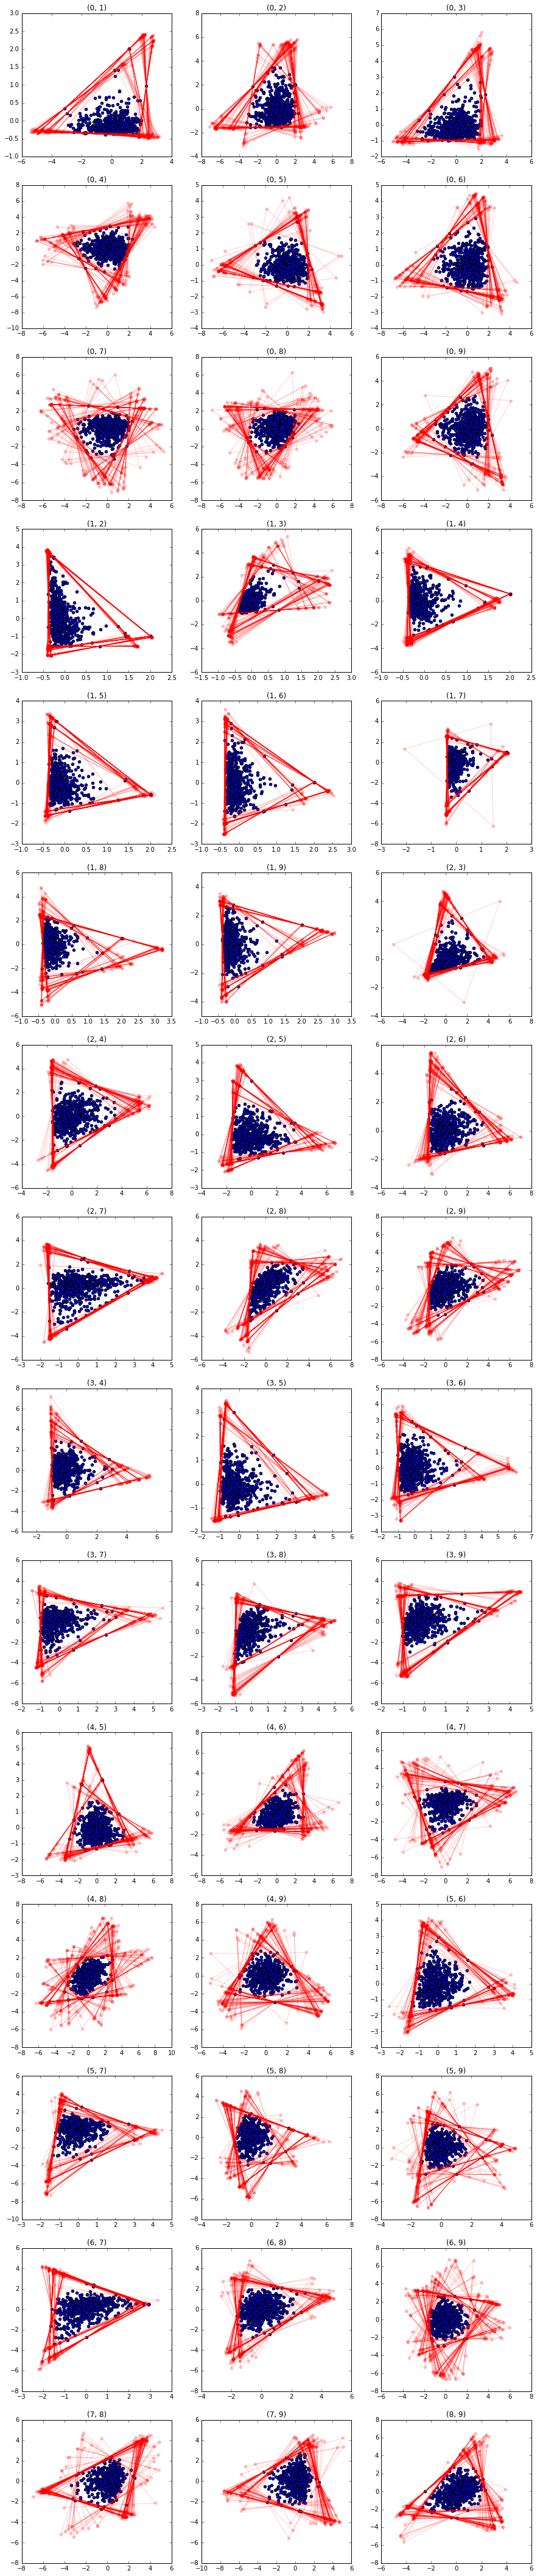

In [5]:
%matplotlib inline
import numpy as np
X = np.loadtxt('../build_dataset/data/X.csv', delimiter=",")
from build_S import Build_S
P, T, C, STD_orig, STD_shuf, pair_triangles_orig, pair_triangles_shuf = Build_S(X,100,sample_size=1.0).main(visualize=True)

In [6]:
import pandas as pd
pd.DataFrame(P)

,0,1,2,3,4,5,6,7,8,9
0,0,0.21,0.06,0.11,0.22,0.90,0.25,0.31,0.13,0.03
1,0,0.00,0.00,0.28,0.45,0.41,0.24,0.99,0.35,0.53
2,0,0.00,0.00,0.00,0.53,0.16,0.35,0.19,0.02,0.08
3,0,0.00,0.00,0.00,0.48,0.60,0.67,0.02,0.01,0.10
4,0,0.00,0.00,0.00,0.00,0.25,0.14,0.24,0.09,0.63
5,0,0.00,0.00,0.00,0.00,0.00,0.26,0.13,0.26,0.46
6,0,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.64,0.05
7,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.47,0.44
8,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [12]:
np.array([['a1','b1','c1'],['a2','b2','c2']]).T.reshape(-1,2)

array([['a1', 'a2'],
       ['b1', 'b2'],
       ['c1', 'c2']], 
      dtype='|S2')